In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [7]:
import attr
import re
import numpy as np

from collections import Counter, defaultdict
from itertools import islice
from boltons.iterutils import windowed
from tqdm import tqdm_notebook
from textblob import TextBlob

from scipy.stats import spearmanr

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [8]:
class Corpus:
    
    def __init__(self, path, skim=None):
        self.path = path
        self.skim = skim
        
    def lines(self):
        with open(self.path) as fh:
            for line in fh:
                yield line.strip()
    
    def abstract_lines(self):
        lines = []
        for line in self.lines():
            if line:
                lines.append(line)
            else:
                yield lines
                lines = []

    def abstracts(self):
        ab_lines = self.abstract_lines()
        if self.skim:
            ab_lines = islice(ab_lines, self.skim)
        for lines in tqdm_notebook(ab_lines):
            yield Abstract.from_lines(lines)
            
    def xy(self, vocab):
        for abstract in self.abstracts():
            yield from abstract.xy(vocab)
            
    def ngram_counts(self, n):
        counts = defaultdict(lambda: 0)
        for ab in self.abstracts():
            for sent in ab.sentences:
                for ngram in sent.ngrams(n):
                    counts[ngram] += 1
        return Counter(counts)
            
    def most_common_ngrams(self, n, depth):
        counts = self.ngram_counts(n)
        return set([k for k, _ in counts.most_common(depth)])

In [14]:
@attr.s
class Abstract:
    
    identifier = attr.ib()
    tags = attr.ib()
    sentences = attr.ib()
    
    @classmethod
    def from_lines(cls, lines):
        sentences = list(map(Sentence, lines[2:]))
        return cls(lines[0], lines[1].split(), sentences)
    
    def sentence_tokens(self):
        for sent in self.sentences:
            yield re.findall('[a-z]+', sent.lower())
    
    def xy(self, vocab):
        for i, sent in enumerate(self.sentences):
            x = sent.features(vocab)
            y = i / (len(self.sentences)-1)
            yield x, y

In [15]:
class Sentence:
    
    def __init__(self, text):
        self.blob = TextBlob(text)
        
    def tokens(self):
        return list(self.blob.tokens)
    
    def ngrams(self, n=1):
        for ng in windowed(self.tokens(), n):
            yield '_'.join(ng)
            
    def ngram_counts(self, vocab, maxn=3):
        for n in range(1, maxn+1):
            counts = Counter(self.ngrams(n))
            for k, v in counts.items():
                if k in vocab:
                    yield f'_{k}', v
                    
    def word_count(self):
        return len(list(self.ngrams(1)))
                
    def _features(self, vocab):
        yield from self.ngram_counts(vocab)
        yield 'word_count', self.word_count()
        
    def features(self, vocab):
        return dict(self._features(vocab))

In [16]:
train = Corpus('../data/abstracts/train.txt', 100000)

In [17]:
vocab = (
    train.most_common_ngrams(1, 2000) |
    train.most_common_ngrams(2, 2000) |
    train.most_common_ngrams(3, 2000)
)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [20]:
dv = DictVectorizer()

In [21]:
train_x, train_y = zip(*train.xy(vocab))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [22]:
train_x = dv.fit_transform(train_x)

In [23]:
train_x

<537608x6001 sparse matrix of type '<class 'numpy.float64'>'
	with 15744810 stored elements in Compressed Sparse Row format>

In [24]:
model = LinearRegression()

In [25]:
fit = model.fit(train_x, train_y)

In [26]:
test = Corpus('../data/abstracts/test.txt', 50000)

In [27]:
test_x, test_y = zip(*test.xy(vocab))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [28]:
test_x = dv.transform(test_x)

In [29]:
r2_score(test_y, fit.predict(test_x))

0.32400767102412564

In [30]:
names = dv.get_feature_names()

In [31]:
bidx = fit.coef_.argsort()
eidx = np.flip(fit.coef_.argsort(), 0)

In [32]:
for i in bidx[:50]:
    print(fit.coef_[i], names[i])

-0.266546266594 _Let
-0.236484510711 _Recent
-0.231855080922 _We_study
-0.219540826668 _in_terms_of
-0.207698285101 _We_report
-0.201042097052 _M__{
-0.19591955639 _In_addition_to
-0.195195605708 _We_investigate
-0.191597215165 _This_paper
-0.190442883633 _We_consider
-0.185266561338 _Recently
-0.182951160254 _is_proposed_.
-0.180322830699 _We_present
-0.178625818263 _this_paper_.
-0.173903109756 _is_well_known
-0.168648868943 _the_context_of
-0.166948797856 _We_review
-0.16169720055 _is_one_of
-0.161315879641 _$__2
-0.159517192417 _We_introduce
-0.156949507942 _Sloan_Digital_Sky
-0.1552505477 _The_problem_of
-0.152335085063 _In_the_first
-0.148400379036 _One_of_the
-0.140703451359 _the_framework_of
-0.14004564946 _is_considered
-0.139853183054 _for_example
-0.139108578239 _often
-0.13886958204 _article
-0.137688060182 _with_respect_to
-0.136684840905 _We_construct
-0.136518752261 _We_prove
-0.136081285654 _is_devoted_to
-0.133521965758 _usually
-0.133301509911 _is_studied
-0.131275447

In [33]:
for i in eidx[:50]:
    print(fit.coef_[i], names[i])

0.364761729788 _Finally
0.234796568247 _Furthermore
0.234685423131 _In_addition
0.229464516328 _Also
0.224865580184 _We_have_also
0.223074873731 _M_
0.219429605628 _Moreover
0.209241764811 _conclude
0.208318135264 _comment_on_the
0.207143106289 _Thus
0.206224710241 _Further
0.205191644428 _in_terms
0.191668331405 _(_ii_)
0.183650995931 _implications
0.17697692498 _In_this_way
0.169174674005 _light_on_the
0.168479866395 _illustrate
0.168298534575 _We_conclude
0.167801528467 _findings
0.164622682918 _can_be_understood
0.157619584575 _Therefore
0.156300873612 _In_particular
0.155828704388 _with_respect
0.155124389274 _We_also
0.151466025506 _The_proposed
0.151070740759 _In_this_case
0.15082062373 _Our
0.149785536321 _$__2_$
0.14805951089 _suggests
0.147077376732 _These_results
0.145695721045 _examples
0.143731363237 _paper_.
0.143355592031 _are_shown
0.143106102926 _We_propose_that
0.137908170895 _thus
0.135423057974 _the_other_hand
0.13536320612 _the_proposed
0.133595792035 _consequence


In [35]:
correct = Counter()
total = Counter()

for ab in test.abstracts():
    
    x, _ = zip(*ab.xy(vocab))
    x = dv.transform(x)
    
    order = list(fit.predict(x).argsort().argsort())
    
    if sorted(order) == order:
        correct[len(order)] += 1
        
    total[len(order)] += 1

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/dclure/Projects/plot-ordering/env/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/bin/../Cellar/python3/3.6.2/bin/../Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [36]:
for slen in sorted(correct.keys()):
    print(slen, correct[slen] / total[slen])

2 0.8835944299390774
3 0.5527894804034215
4 0.25656894679695985
5 0.08528864059590316
6 0.024516737388024516
7 0.006248653307476837
8 0.0018023430459597476
9 0.0004361098996947231
11 0.0010193679918450561


In [37]:
sum(correct.values()) / sum(total.values())

0.23268

# Sentence length vs. percentage correct

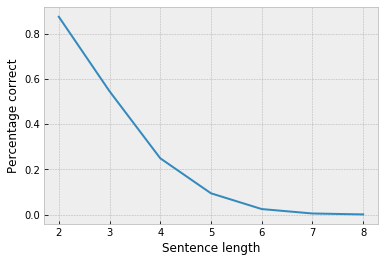

In [33]:
x = sorted(correct.keys())
y = [correct[slen] / total[slen] for slen in x]

plt.xlabel('Sentence length')
plt.ylabel('Percentage correct')
plt.plot(x, y)

In [40]:
srank = defaultdict(list)

for ab in tqdm_notebook(test.abstracts()):
    
    x, _ = zip(*ab.xy(vocab))
    x = dv.transform(x)
    
    order = list(fit.predict(x).argsort().argsort())
    
    score, _ = spearmanr(order, sorted(order))
    
    srank[len(order)].append(score)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

# Sentence length vs. Spearman rank-order correlation

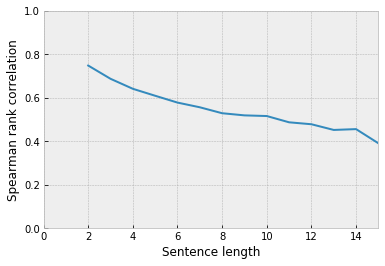

In [46]:
x = sorted(srank.keys())
y = [np.mean(srank[slen]) for slen in x]

plt.xlim((0, 15))
plt.ylim((0, 1))
plt.xlabel('Sentence length')
plt.ylabel('Spearman rank correlation')
plt.plot(x, y)